In [37]:
from scipy.spatial.transform import Rotation
import numpy as np
import scipy
import pathlib
import h5py
import healpy as hp

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle 
from astropy.stats import median_absolute_deviation as mad_
from astropy.coordinates import CartesianRepresentation, SphericalRepresentation
import gala.dynamics as gd
import gala.coordinates as gc
from mwlmc import model as mwlmc_model
Model = mwlmc_model.MWLMC()
import yaml

import matplotlib
import matplotlib.pyplot as plt
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('my_standard.mplstyle')

galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
galcen_distance = 8.249*u.kpc

Initialising MW ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising LMC ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising MW disc ... 
cylcoefs::read_simple_coef_file: reading coefficients from file . . . success!!


sphcache::read_sph_cache: trying to read cached table . . . success!!
sphcache::read_sph_cache: trying to read cached table . . . success!!
cylcache::read_cyl_cache: trying to read cached table . . . success!!


In [17]:
def mollweide_projection(l, b, l2, b2, title, bmin, bmax, nside, smooth, q=[0], **kwargs):

    """
    Makes mollweide plot using healpix
    Parameters:
    ----------- 
    l : numpy.array in degrees 
    b : numpy.array in degrees [-90, 90]
    """
 
    times = '/mnt/ceph/users/firesims/fire2/metaldiff/{}_res7100/snapshot_times.txt'.format('m12b')

    mwlmc_indices = hp.ang2pix(nside,  (90-b)*np.pi/180., l*np.pi/180.)
    npix = hp.nside2npix(nside)
 
    idx, counts = np.unique(mwlmc_indices, return_counts=True)
    degsq = hp.nside2pixarea(nside, degrees=True)
    # filling the full-sky map
    hpx_map = np.zeros(npix, dtype=float)
    if q[0] != 0 :    
        counts = np.zeros_like(idx, dtype=float)
        k=0
        for i in idx:
            pix_ids = np.where(mwlmc_indices==i)[0]
            counts[k] = np.mean(q[pix_ids])
            k+=1
        hpx_map[idx] = counts
    else :
       hpx_map[idx] = counts/degsq
    
    map_smooth = hp.smoothing(hpx_map, fwhm=smooth*np.pi/180)
    
    if 'cmap' in kwargs.keys():
        cmap = kwargs['cmap']
    else:
        cmap='viridis'
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    plt.close()
    projview(
      map_smooth,
      coord=["G"],
      graticule=True,
      graticule_labels=True,
      rot=(0, 0, 0),
      unit=" ",
      xlabel="Galactic Longitude (l) ",
      ylabel="Galactic Latitude (b)",
      cb_orientation="horizontal",
      min=bmin,
      max=bmax,
      latitude_grid_spacing=45,
      projection_type="mollweide",
      title=title,
      cmap=cmap,
      fontsize={
              "xlabel": 25,
              "ylabel": 25,
              "xtick_label": 20,
              "ytick_label": 20,
              "title": 25,
              "cbar_label": 20,
              "cbar_tick_label": 20,
              },
      )
	
    newprojplot(theta=np.radians(90-(b2)), phi=np.radians(l2), marker="o", color="yellow", markersize=5, lw=0, mfc='none')
    if 'l3' in kwargs.keys():
        l3 = kwargs['l3']
        b3 = kwargs['b3']
        newprojplot(theta=np.radians(90-(b3)), phi=np.radians(l3), marker="o", color="yellow", markersize=5, lw=0)
    elif 'l4' in kwargs.keys():
        l4 = kwargs['l4']
        b4 = kwargs['b4']
        newprojplot(theta=np.radians(90-(b4)), phi=np.radians(l4), marker="*", color="r", markersize=8, lw=0)

    #newprojplot(theta=np.radians(90-(b2[0])), phi=np.radians(l2[0]-120), marker="*", color="r", markersize=5 )
    #newprojplot(theta=np.radians(90-(b2[1])), phi=np.radians(l2[1]-120), marker="*", color="w", markersize=2 )
    
    if 'figname' in kwargs.keys():
        print("* Saving figure in ", kwargs['figname'])
        plt.savefig(kwargs['figname'], bbox_inches='tight')
        plt.close()
    #return 0

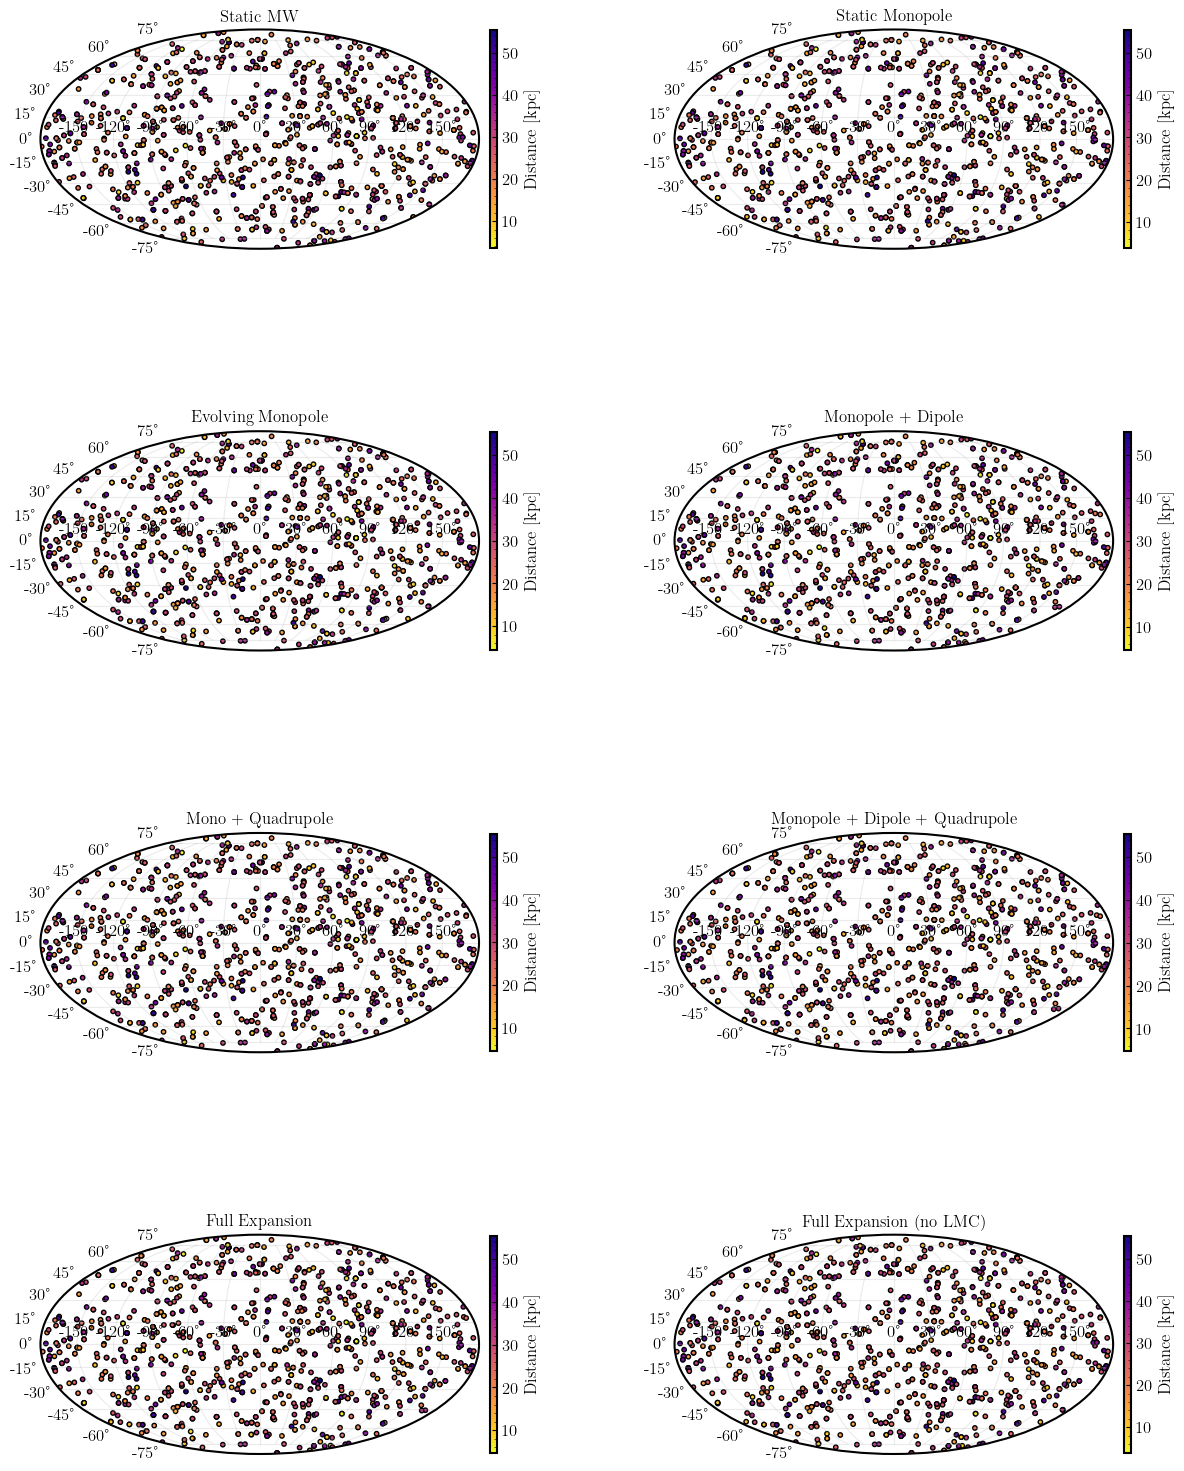

In [45]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/'

potentials = list(['static-mwh-only.hdf5','rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5',\
                       'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5',\
                       'Full-MWhalo-MWdisc-LMC.hdf5', 'full-MWhalo-full-MWdisc-no-LMC.hdf5'])

labels = list(['Static MW','Static Monopole', 'Evolving Monopole', 'Monopole + Dipole', 'Mono + Quadrupole', \
               'Monopole + Dipole + Quadrupole', 'Full Expansion', 'Full Expansion (no LMC)'])

pltidx = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1), (3,0), (3,1), (4,0), (4,1)]

fig, ax = plt.subplots(4, 2, subplot_kw={'projection': 'mollweide'}, figsize=(15, 20))

for j in range(len(potentials)):  #len(potentials)
    
    with h5py.File(path + potentials[j],'r') as file:
        # print(file.keys())
        
        l_gc = np.array(file['l_gc'])
        l_gc_wrap = Angle(l_gc * u.deg)
        b_gc = np.array(file['b_gc'])
        ds = np.array(file['ds'])
        loc_veldis = np.array(file['loc_veldis'])
        
        l_pole = np.array(file['pole_l'])
        l_pole_std = np.array(file['sigma_pole_l'])
        b_pole = np.array(file['pole_b'])
        b_pole_std = np.array(file['sigma_pole_b'])
        vlos = np.array(file['vlos'])
        sigmavlos = np.array(file['sigmavlos'])
        
    
    plt.sca(ax[pltidx[j]])
    plt.grid(alpha=.25)
    # sc=plt.scatter(l_gc_wrap.wrap_at(180*u.deg).to(u.rad), (b_gc*u.deg).to(u.rad), s=10,
    #            c=ds, cmap='plasma_r', edgecolor='k', rasterized=True)
    sc=plt.scatter((l_pole*u.deg).to(u.rad), (b_pole*u.deg).to(u.rad), s=10,
               c=ds, cmap='plasma_r', edgecolor='k', rasterized=True)

    cb=plt.colorbar(sc,location='right', aspect=30, pad=0.02, shrink=.65)
    cb.set_label(r'Distance [kpc]')
    cb.ax.tick_params(labelsize=12)
    
    plt.title(labels[j])